# 06.03 - Feature Engineering

## Imports & setup

In [1]:
import pathlib
from datetime import datetime
import math
import sys

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from skoot.feature_selection import FeatureFilter
from skoot.preprocessing import SelectiveRobustScaler

sys.path.append("..")
from src.models.models import SetTempAsPower, SK_Prophet
from src.utils.utils import bound_precision, AnnualTimeSeriesSplit
from src.visualization.visualize import (plot_prediction,
                                         plot_joint_plot,
                                         residual_plots,
                                         print_residual_stats,
                                         seasonal_plot)

%matplotlib inline

PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'


pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Load Daily Data & Inspect

In [2]:
df = pd.read_csv(CLEAN_DATA_DIR / 'clean-features.csv', parse_dates=True, index_col=0)

In [3]:
df.head()

,hmdxx_min,hmdxx_max,hmdxx_median-1,hmdxx_max_hour,temp_min,temp_max,dew_point_temp_max,sun_rise,sun_set,visibility_mean,day_of_week,week_of_year,day_type,daily_peak
1994-05-24,8.998045,19.818202,19.655075,15.0,9.0,19.6,13.4,6.0,21.0,24.975000,1.0,21.0,2,16173.0
1994-05-25,11.406291,20.665711,17.205396,18.0,10.4,18.2,14.0,6.0,21.0,9.358333,2.0,21.0,0,16017.0
1994-05-26,2.563201,15.259916,17.722172,2.0,3.9,13.0,12.3,6.0,21.0,9.650000,3.0,21.0,0,16656.0
1994-05-27,-0.012865,12.970553,6.567827,17.0,2.0,14.8,2.3,6.0,21.0,34.500000,4.0,21.0,0,16252.0
1994-05-30,13.632519,30.133976,18.724332,14.0,13.1,27.2,13.6,6.0,21.0,22.270833,0.0,22.0,0,16525.0


In [4]:
df.tail()

,hmdxx_min,hmdxx_max,hmdxx_median-1,hmdxx_max_hour,temp_min,temp_max,dew_point_temp_max,sun_rise,sun_set,visibility_mean,day_of_week,week_of_year,day_type,daily_peak
2018-10-01,7.548996,13.718202,11.013424,23.0,7.8,12.3,10.3,8.0,19.0,16.291667,0.0,40.0,0,16531.0
2018-10-02,9.447222,15.264688,9.228735,14.0,9.2,12.9,12.2,8.0,19.0,10.729167,1.0,40.0,0,16772.0
2018-10-03,12.186593,20.369401,12.113850,23.0,11.0,16.4,15.0,8.0,19.0,22.966667,2.0,40.0,0,16212.0
2018-10-04,6.612192,30.070535,15.509242,4.0,7.9,22.5,20.5,8.0,19.0,23.433333,3.0,40.0,0,16061.0
2018-10-05,3.412831,12.228666,19.348456,23.0,5.4,12.1,7.3,8.0,19.0,24.100000,4.0,40.0,0,16269.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2400 entries, 1994-05-24 to 2018-10-05
Data columns (total 14 columns):
hmdxx_min             2400 non-null float64
hmdxx_max             2400 non-null float64
hmdxx_median-1        2400 non-null float64
hmdxx_max_hour        2400 non-null float64
temp_min              2400 non-null float64
temp_max              2400 non-null float64
dew_point_temp_max    2400 non-null float64
sun_rise              2400 non-null float64
sun_set               2400 non-null float64
visibility_mean       2400 non-null float64
day_of_week           2400 non-null float64
week_of_year          2400 non-null float64
day_type              2400 non-null int64
daily_peak            2400 non-null float64
dtypes: float64(13), int64(1)
memory usage: 281.2 KB


## Custom Transformers

### CyclicalToCycle Transformer

Transforms cyclical data from original format into sin and cosine waves.

Without transformation 23:55 (11:55PM) and 0:05 AM look like they are very far apart, whereas in fact they are very close - only 10 minutes apart.

Transformation into sin and cosine waves rectifies this problem. However, it means that 2 columns are neded to specify the feature instead of one.

http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/


In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class CyclicalToCycle(BaseEstimator, TransformerMixin):
    """ A transformer that returns the sin and cosine values of a cyclical sequence
    For more information regarding how to build your own transformer, read more
    in the :ref:`User Guide <user_guide>`.
    Parameters
    ----------
    demo_param : str, default='demo'
        A parameter used for demonstation of how to pass and store paramters.
    Attributes
    ----------
    n_features_ : int
        The number of features of the data passed to :meth:`fit`.
    """
    def __init__(self, cycle_name='time_of_day', periods_per_cycle=24):
        self.cycle_name=cycle_name
        self.periods_per_cycle= periods_per_cycle

    def fit(self, X, y=None):
        """A reference implementation of a fitting function for a transformer.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : None
            There is no need of a target in a transformer, yet the pipeline API
            requires this parameter.
        Returns
        -------
        self : object
            Returns self.
        """
        return self

    def transform(self, X):
        """ A reference implementation of a transform function.
        Parameters
        ----------
        X : {array-like, sparse-matrix}, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        X_transformed : array, shape (n_samples, n_features)
            The array containing the element-wise square roots of the values
            in ``X``.
        """
        X = X.copy(deep=True)
        X['sin_' + self.cycle_name] = np.sin(2*np.pi*X[self.cycle_name] / self.periods_per_cycle)
        X['cos_' + self.cycle_name] = np.cos(2*np.pi*X[self.cycle_name] / self.periods_per_cycle)
        X.drop([self.cycle_name], axis=1, inplace=True)
        
        return X

In [7]:
df = df.loc['1994': '1998']
y = df.pop('daily_peak')
X = df

In [8]:
cycler = CyclicalToCycle(cycle_name='hmdxx_max_hour', periods_per_cycle=24)
cycler.fit(X)
Xt = cycler.transform(X)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [9]:
cycler = CyclicalToCycle(cycle_name='day_of_week', periods_per_cycle=5)
cycler.fit(Xt)
Xt = cycler.transform(Xt)

In [10]:
cycler = CyclicalToCycle(cycle_name='week_of_year', periods_per_cycle=20)
cycler.fit(Xt)
Xt = cycler.transform(Xt)

In [11]:
Xt.head()

,hmdxx_min,hmdxx_max,hmdxx_median-1,temp_min,temp_max,dew_point_temp_max,sun_rise,sun_set,visibility_mean,day_type,sin_hmdxx_max_hour,cos_hmdxx_max_hour,sin_day_of_week,cos_day_of_week,sin_week_of_year,cos_week_of_year
1994-05-24,8.998045,19.818202,19.655075,9.0,19.6,13.4,6.0,21.0,24.975000,2,-0.707107,-7.071068e-01,0.951057,0.309017,0.309017,0.951057
1994-05-25,11.406291,20.665711,17.205396,10.4,18.2,14.0,6.0,21.0,9.358333,0,-1.000000,-1.836970e-16,0.587785,-0.809017,0.309017,0.951057
1994-05-26,2.563201,15.259916,17.722172,3.9,13.0,12.3,6.0,21.0,9.650000,0,0.500000,8.660254e-01,-0.587785,-0.809017,0.309017,0.951057
1994-05-27,-0.012865,12.970553,6.567827,2.0,14.8,2.3,6.0,21.0,34.500000,0,-0.965926,-2.588190e-01,-0.951057,0.309017,0.309017,0.951057
1994-05-30,13.632519,30.133976,18.724332,13.1,27.2,13.6,6.0,21.0,22.270833,0,-0.500000,-8.660254e-01,0.000000,1.000000,0.587785,0.809017


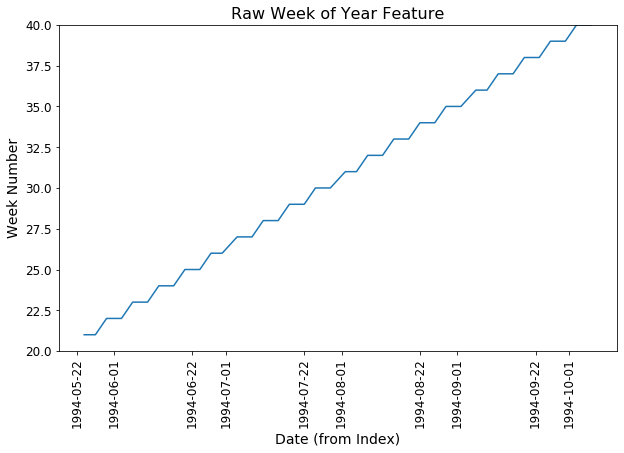

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(X.loc['1994', 'week_of_year'])
ax.set_xlabel('Date (from Index)', fontsize=14)
ax.set_ylabel('Week Number', fontsize=14)
ax.set_ylim(20,40,1)
ax.set_title('Raw Week of Year Feature', fontsize=16)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'raw-cyclic-feature.PNG', bbox_inches='tight')
plt.show();

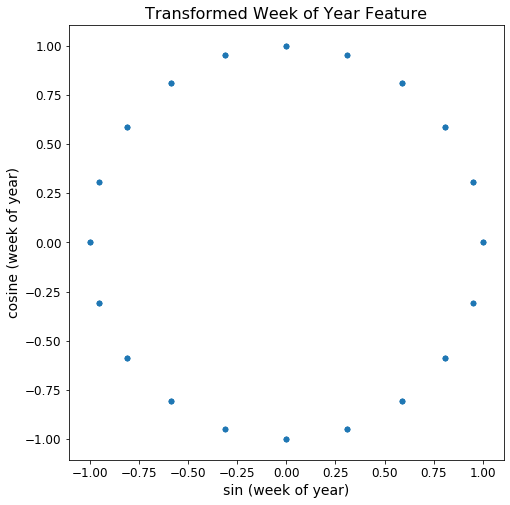

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
Xt.loc['1994'].plot.scatter('sin_week_of_year','cos_week_of_year', ax=ax).set_aspect('equal')
ax.set_xlabel('sin (week of year)', fontsize=14)
ax.set_ylabel('cosine (week of year)', fontsize=14)
ax.set_title('Transformed Week of Year Feature', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'transformed-cyclic-feature.PNG')
plt.show();
